# TP n°1 du module 7 : L'apprentissage non supervisé pour le _Machine Learning_

Dans ce TP, nous allons mettre en pratique les principes de l'apprentissage non supervisé.

Objectifs :
- Passer en revue les principaux algorithmes de clustering
- Comparer les performances de ces différents algorithmes
- Comparer avec les performances de la classification supervisée.

La recherche d'itemsets fréquents et de règles d'associaion ne sera pas abordée dans ce TP.

_NB. : Des messages d'alertes sont suceptibles d'apparaître…_

In [3]:
# Ajoutez ici les imports de librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, OPTICS, Birch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score

import os
os.environ['OMP_NUM_THREADS'] = '4'

Même si ce module concerne l'apprentissage non supervisé, nous allons continuer à explorer le jeu de données du Titanic :
- Cela nous permettra, à la fin, de comparer les clusters obtenus, avec les deux classes réelles obtenus via les labels du jeu de données.

Nous allons donc commencer par charger les données. Pour cela, repartez du csv obtenu à la fin du TP n°1 du module 4 :
- Construisez, comme pour l'apprentissage supervisé, deux dataframe : un avec les attributs, l'autre avec les labels.

In [4]:
titanic = pd.read_csv("Titanic.csv")

X = titanic.drop(['Survived'], axis=1)
y = titanic['Survived']

## 1 - Découverte de KMeans

### Question n°1
Nous allons commencer par faire un premier clustering avec KMeans.
- Comme nous connaissons le nombre de clusters à rechercher, créer un modèle avec la classe de scikit-learn, en fixant le nombre de clusters.
- Appliquez ce clustering aux attributs de _Titanic.csv_
- Récupérer dans une liste le numéro du cluster prédit pour chaque donnée.

In [5]:
km = KMeans(n_clusters=2, n_init='auto')
km.fit(X)
clusters = km.predict(X)
print("⚠Risque de message d'alerte…")

⚠Risque de message d'alerte…


### Question n°2
- Quelle est la classe majoritaire dans le premier cluster ?
- Dans le deuxième cluster ?
- Affichez une matrice, qui donne pour chaque classe le nombre de fois où elle apparaît dans chaque cluster.
- Qu'observez-vous ?

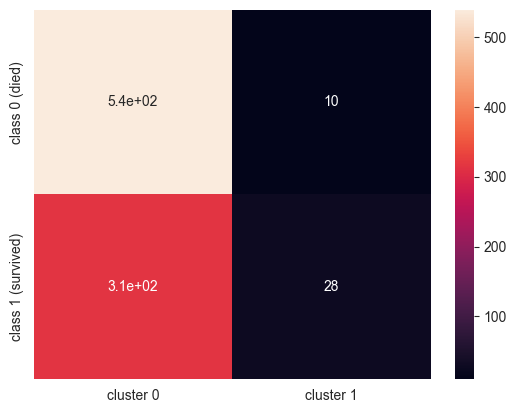

In [6]:
cm = confusion_matrix(y, clusters)
sn.heatmap(cm, annot=True, xticklabels=['cluster 0', 'cluster 1'], yticklabels=['class 0 (died)', 'class 1 (survived)'])
plt.show()

### Question n°3
Faites un pairplot des données du Titanic, en colorant chaque donnée en fonction du cluster auquel elle a été affectée.
- Remarquez-vous des phénomènes intéressants ?

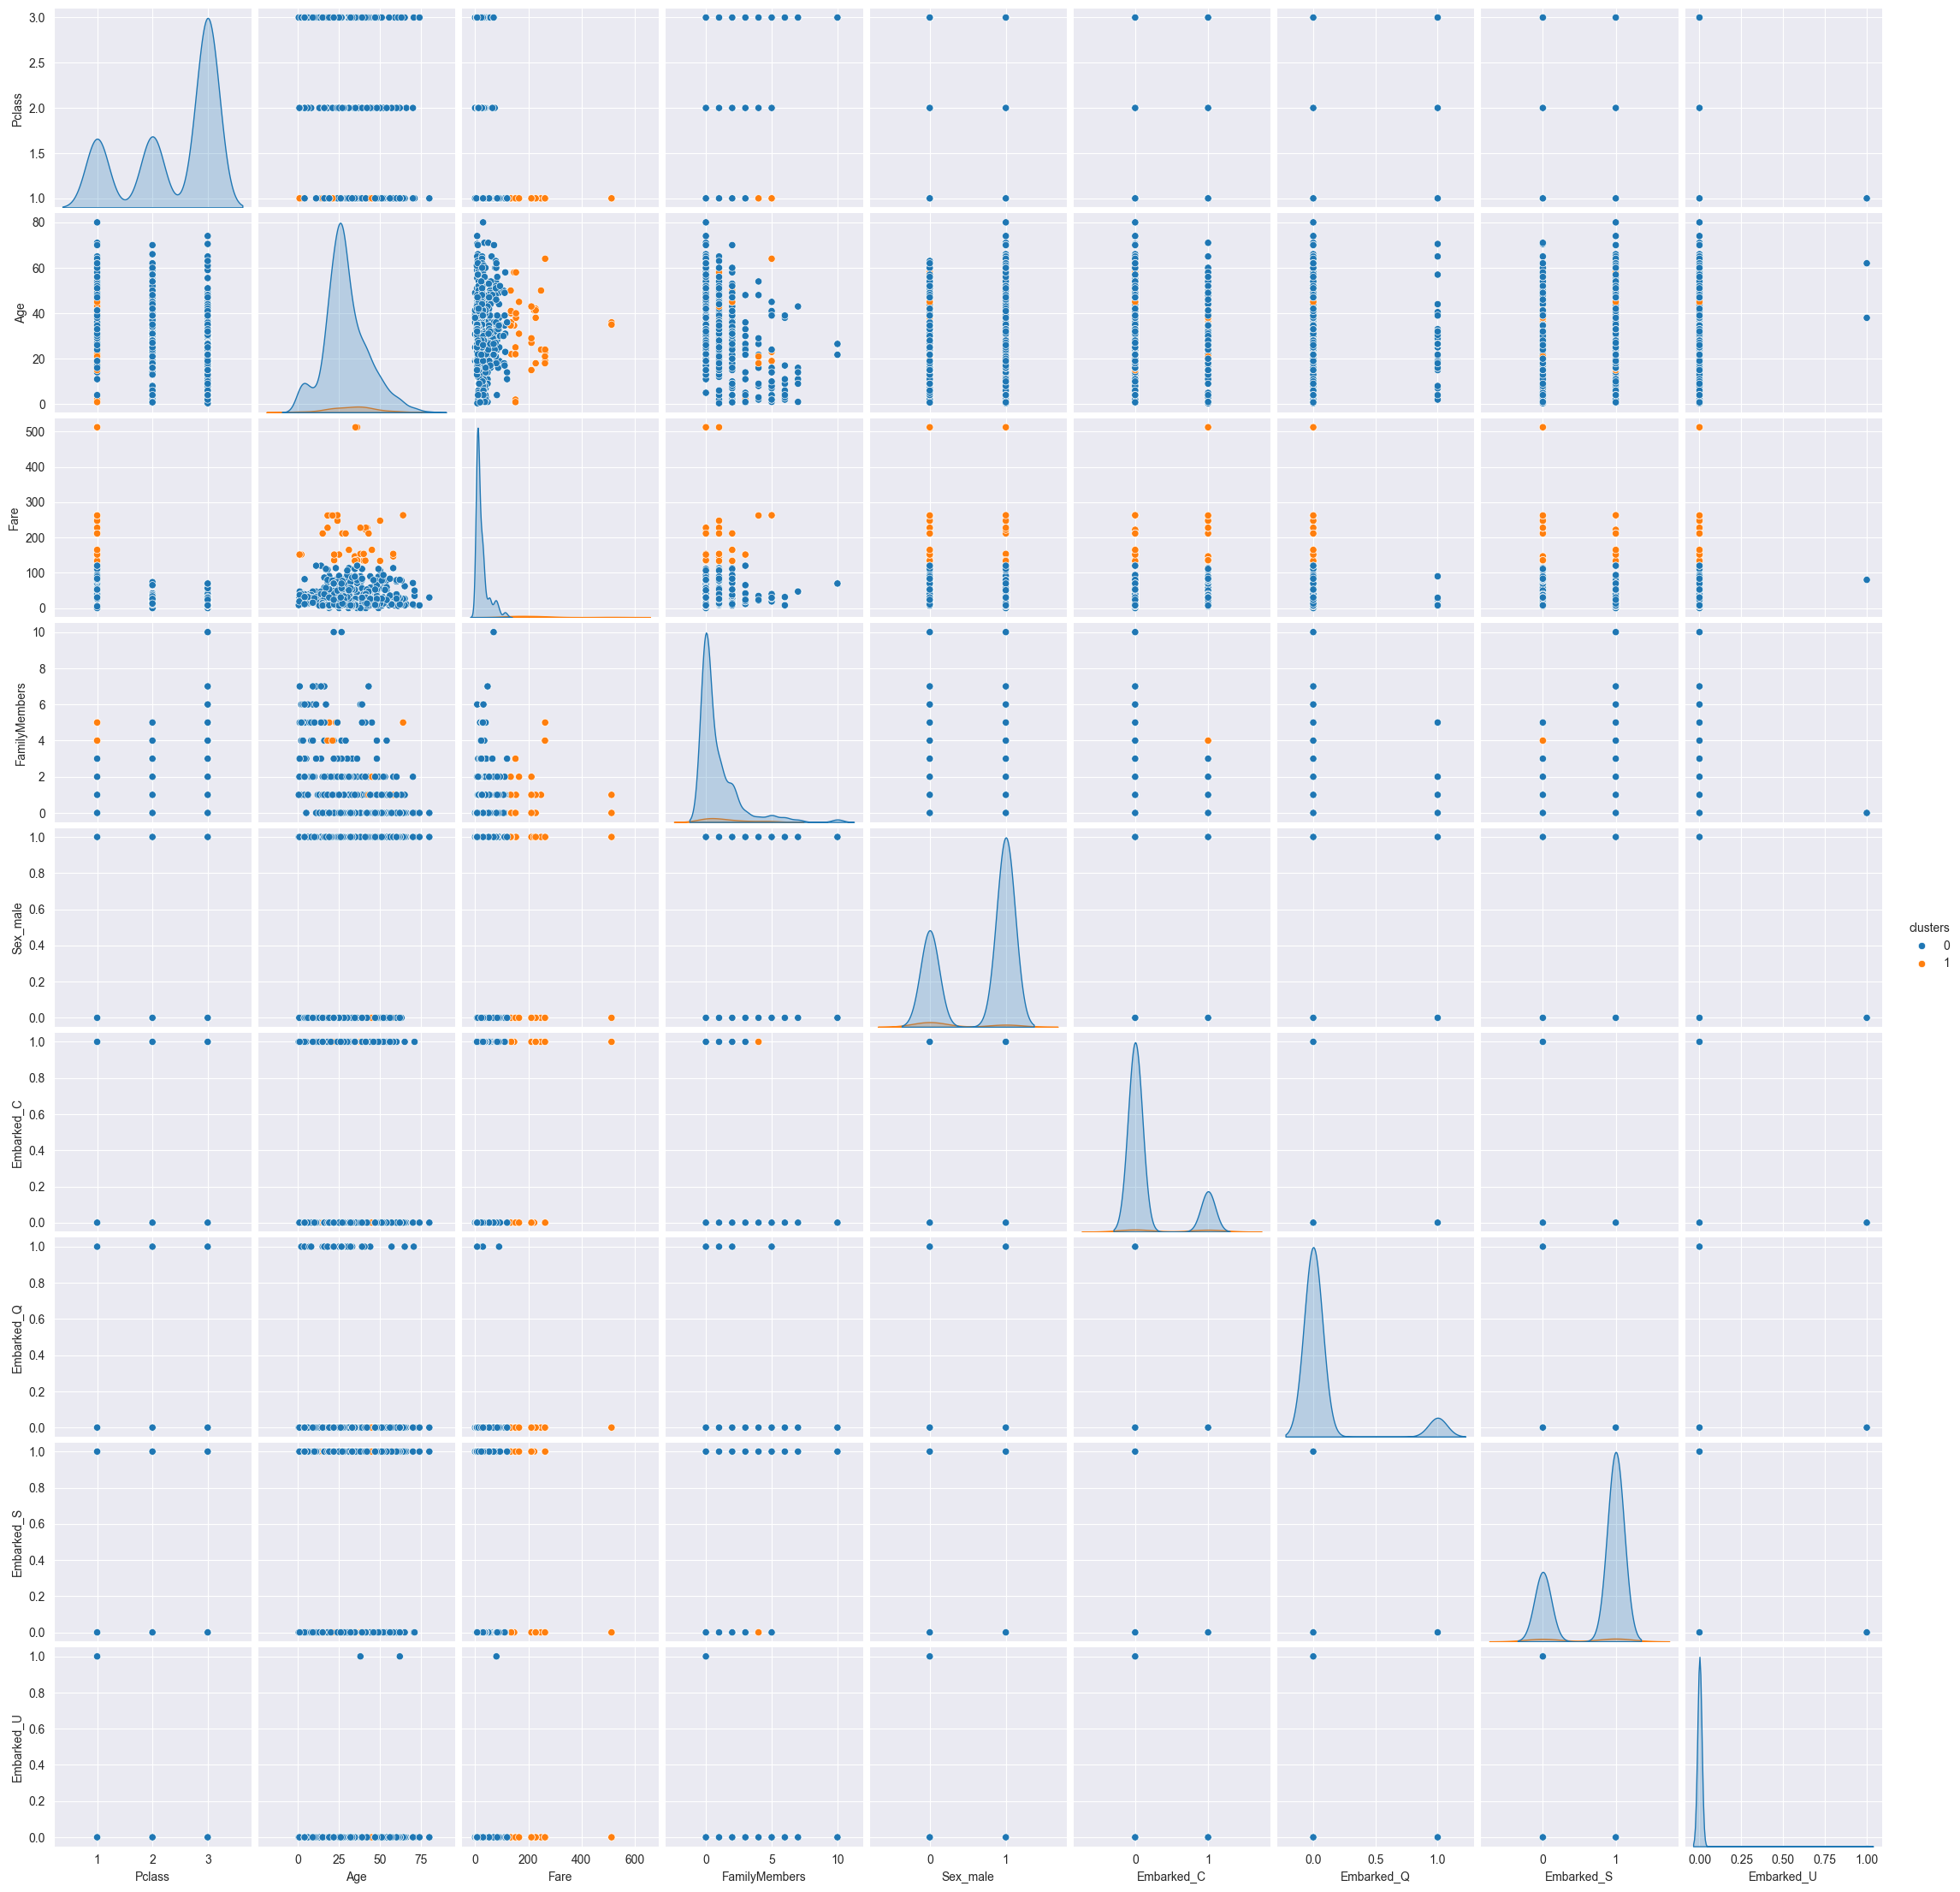

In [7]:
X['clusters'] = clusters
sn.pairplot(X, hue='clusters')

### Question n°4
Les algorithmes de clustering impliquant des mesures de distances sont très sensibles aux plages de valeurs des différents attributs.
- Normalisez vos données, et refaites les mêmes étapes que précédemment.
- Observez-vous une différence ?

[[447 102]
 [173 169]]


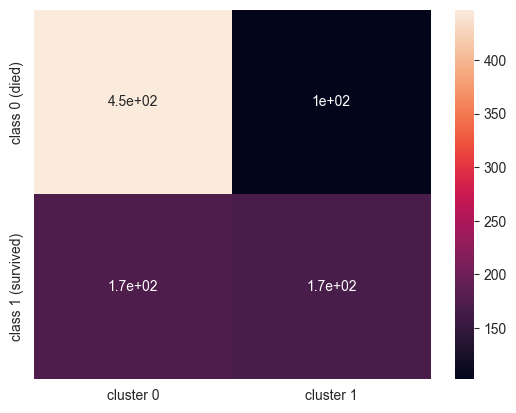

⚠Risque de message d'alerte…


In [8]:
X_normalized = normalize(X)
km2 = KMeans(n_clusters=2, n_init='auto')
clusters_norm = km2.fit_predict(X_normalized)
cm2 = confusion_matrix(y, clusters_norm)
print(cm2)
sn.heatmap(cm2, annot=True, xticklabels=['cluster 0', 'cluster 1'], yticklabels=['class 0 (died)', 'class 1 (survived)'])
plt.show()
print("⚠Risque de message d'alerte…")

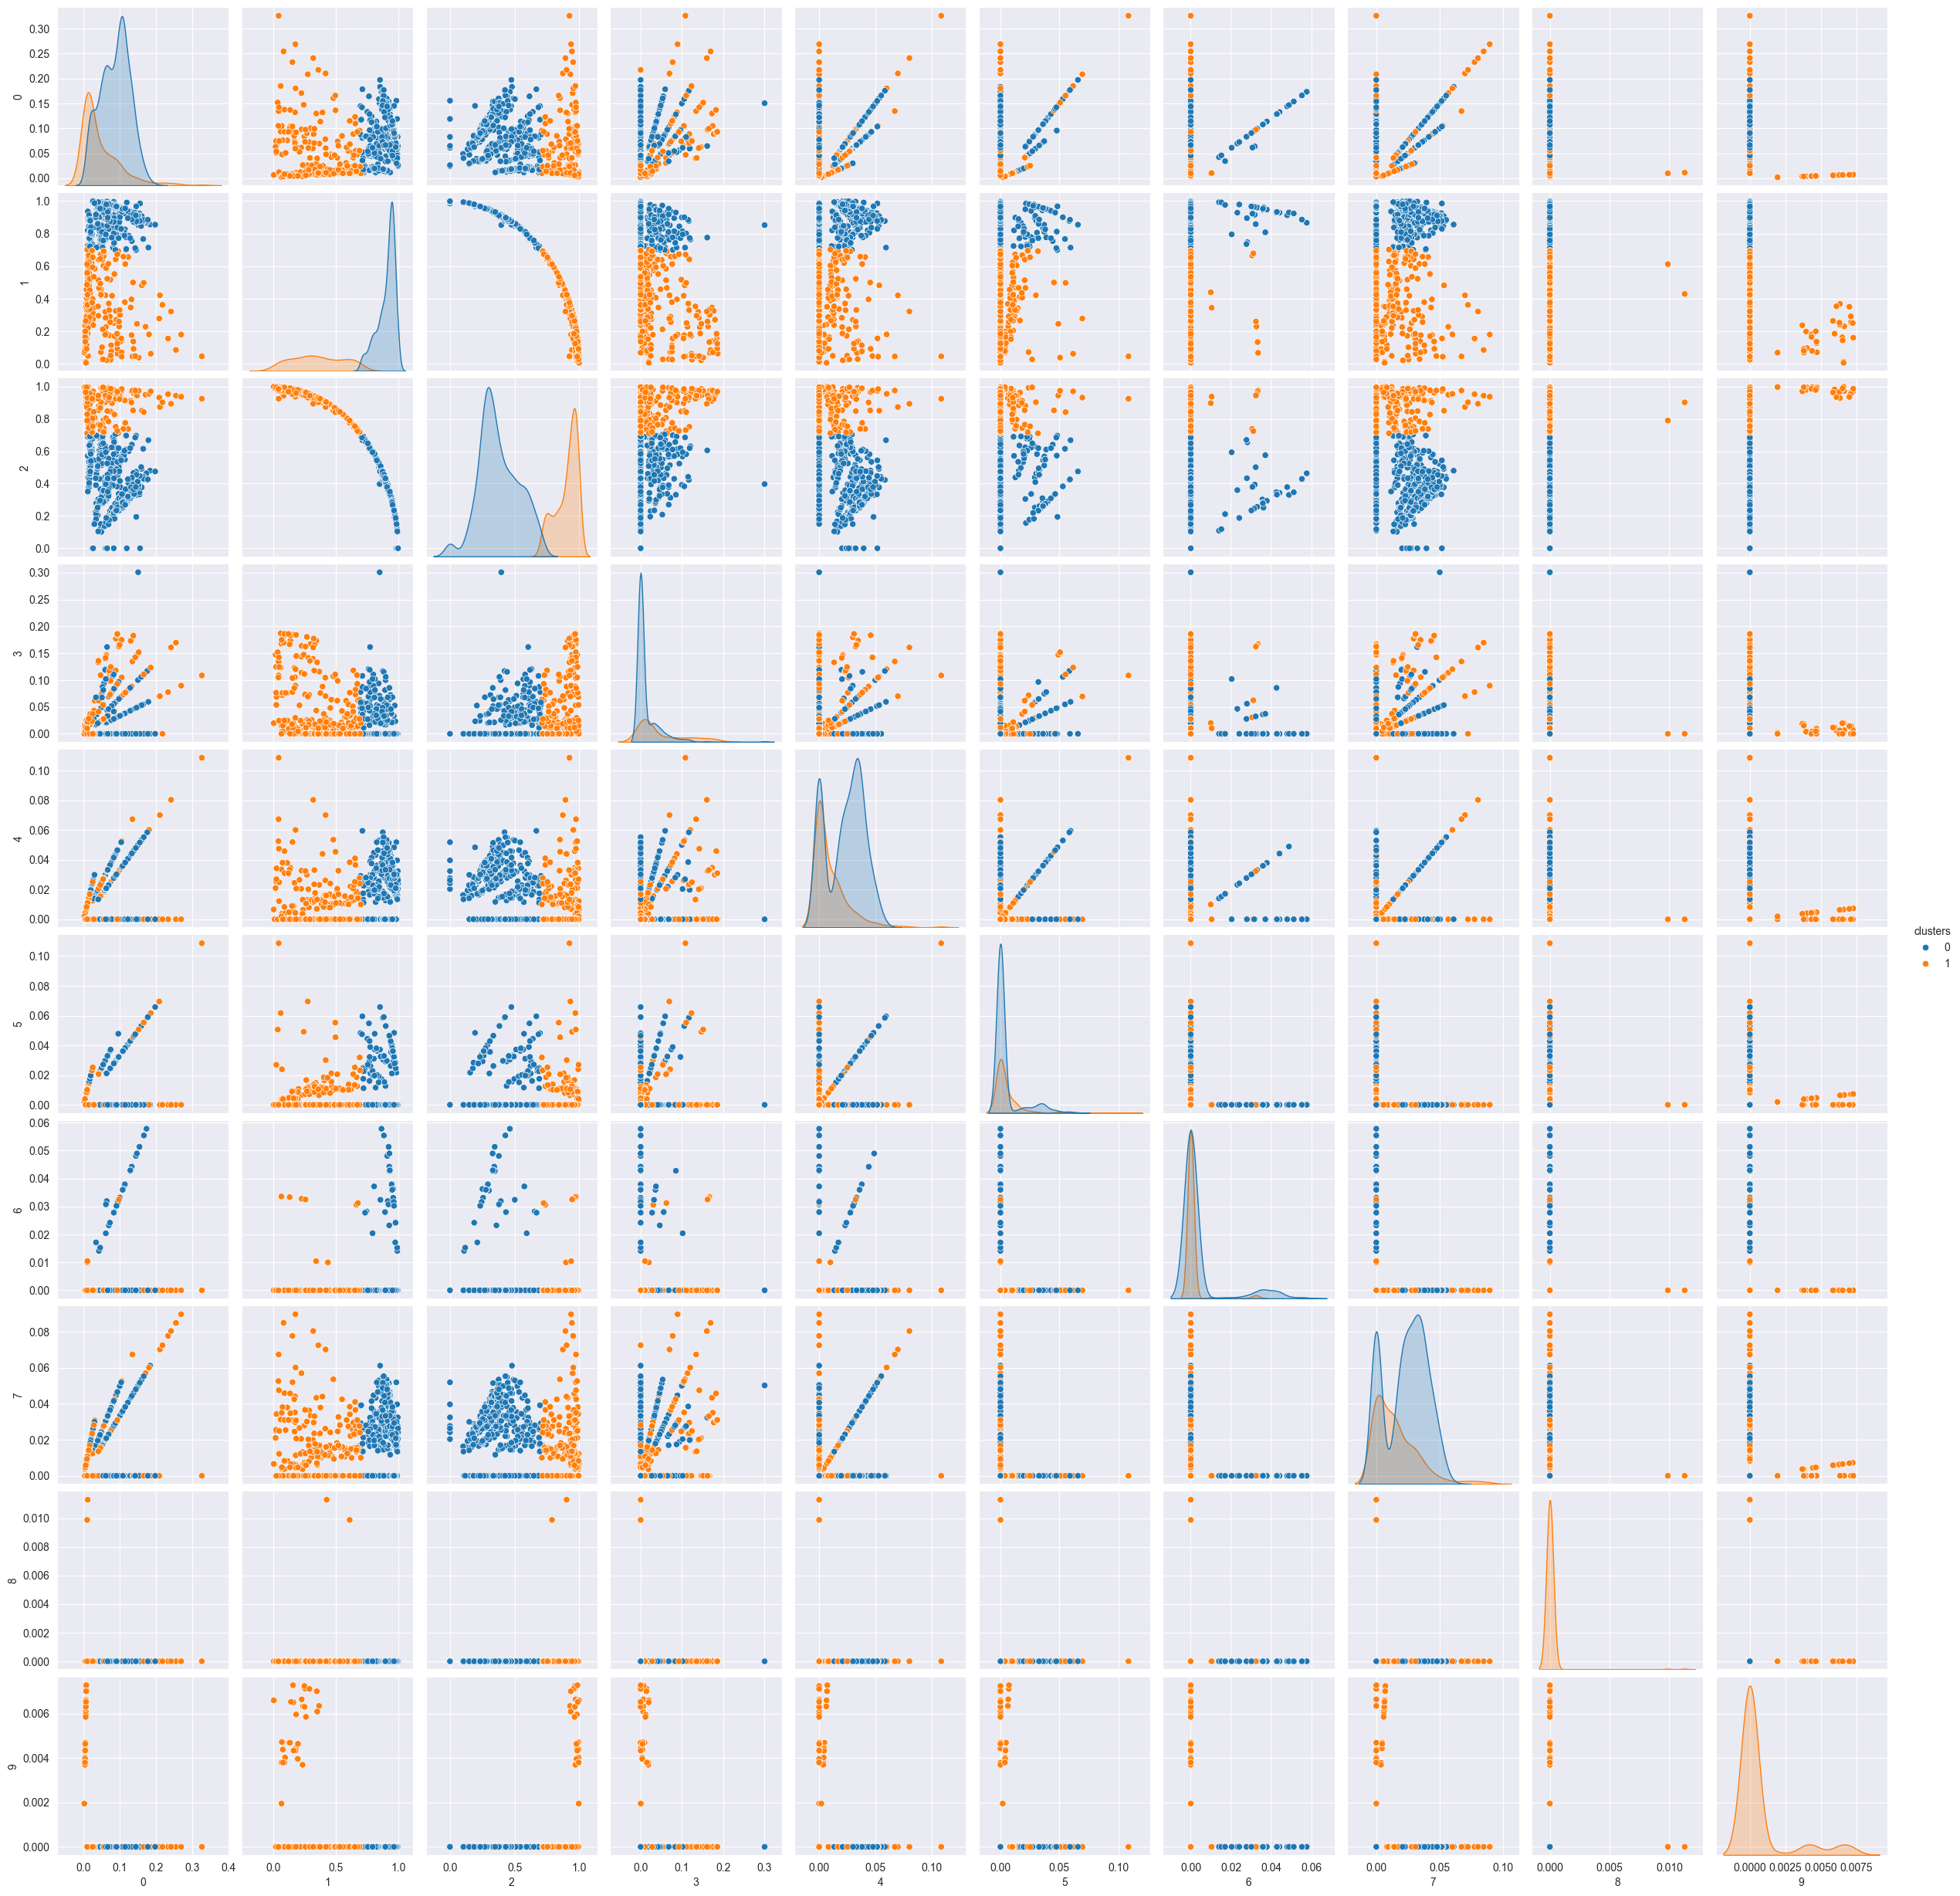

In [9]:
X_normalized_df = pd.DataFrame(X_normalized)
X_normalized_df['clusters'] = clusters_norm
sn.pairplot(X_normalized_df, hue='clusters')

#### Observation :
- Même si la matrice ne reflète pas la réalité des classes sous-jacentes du jeu de données, les clusters sont plus équilibrés, et semblent prendre bien mieux en compte les différents attributs.

### Question n°5
Étudions l'évolution du coefficient de _silhouette_.
- Pour k variant de 2 à 10, tracez l'évolution de ce coefficient pour un clustering kmeans appliqué au données normalisées.
- Le nombre de clusters utilisé aux questions précédentes vous semble-t'il pertinent ?

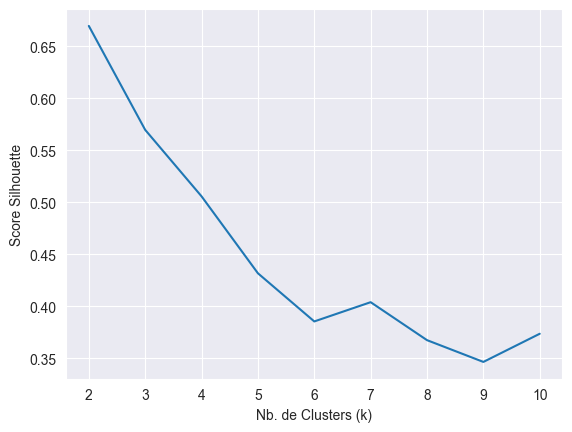

Meilleure coefficient (0.6696472100159327) pour k=2
⚠Risque de message d'alerte…


In [10]:
silhouettes = []
k_values = range(2,11)

for k in k_values:
    model = KMeans(n_clusters=k, n_init='auto')
    clusters_results = model.fit_predict(X_normalized)
    silhouettes.append(silhouette_score(X_normalized, clusters_results))
    
plt.plot(k_values, silhouettes)
plt.xticks(k_values)
plt.xlabel("Nb. de Clusters (k)")
plt.ylabel("Score Silhouette")
plt.show()

print(F"Meilleure coefficient ({np.max(silhouettes)}) pour k={np.argmax(silhouettes) + 2}")
print("⚠Risque de message d'alerte…")

## 2 - Clustering hiérarchique

⚠ Attention : Pour toute la suite du TP, nous travaillerons avec les données normalisées. 

### Question n°1
Créez un modèle de clustering hiérarchique (`AgglomerativeClustering`). En utilisant le coefficient de silhouette, comparez le score obtenu pour deux clusters avec celui obtenu par KMeans sur la section précédente.

In [11]:
clustering_hierarchie = AgglomerativeClustering(n_clusters=2)
clusters = clustering_hierarchie.fit_predict(X_normalized)
print("Coefficient silhouette pour le clustering hiérarchique : ", silhouette_score(X_normalized, clusters))

Coefficient silhouette pour le clustering hiérarchique :  0.6590629902788021


#### Observation :
- Le score obtenu est très légèrement inférieur à celui de Kmeans.

### Question n°2
Représentez graphiquement ce nouveau clustering, à l'aide d'un pairplot.
- Remarquez-vous des tendances ou des changements intéressants ?

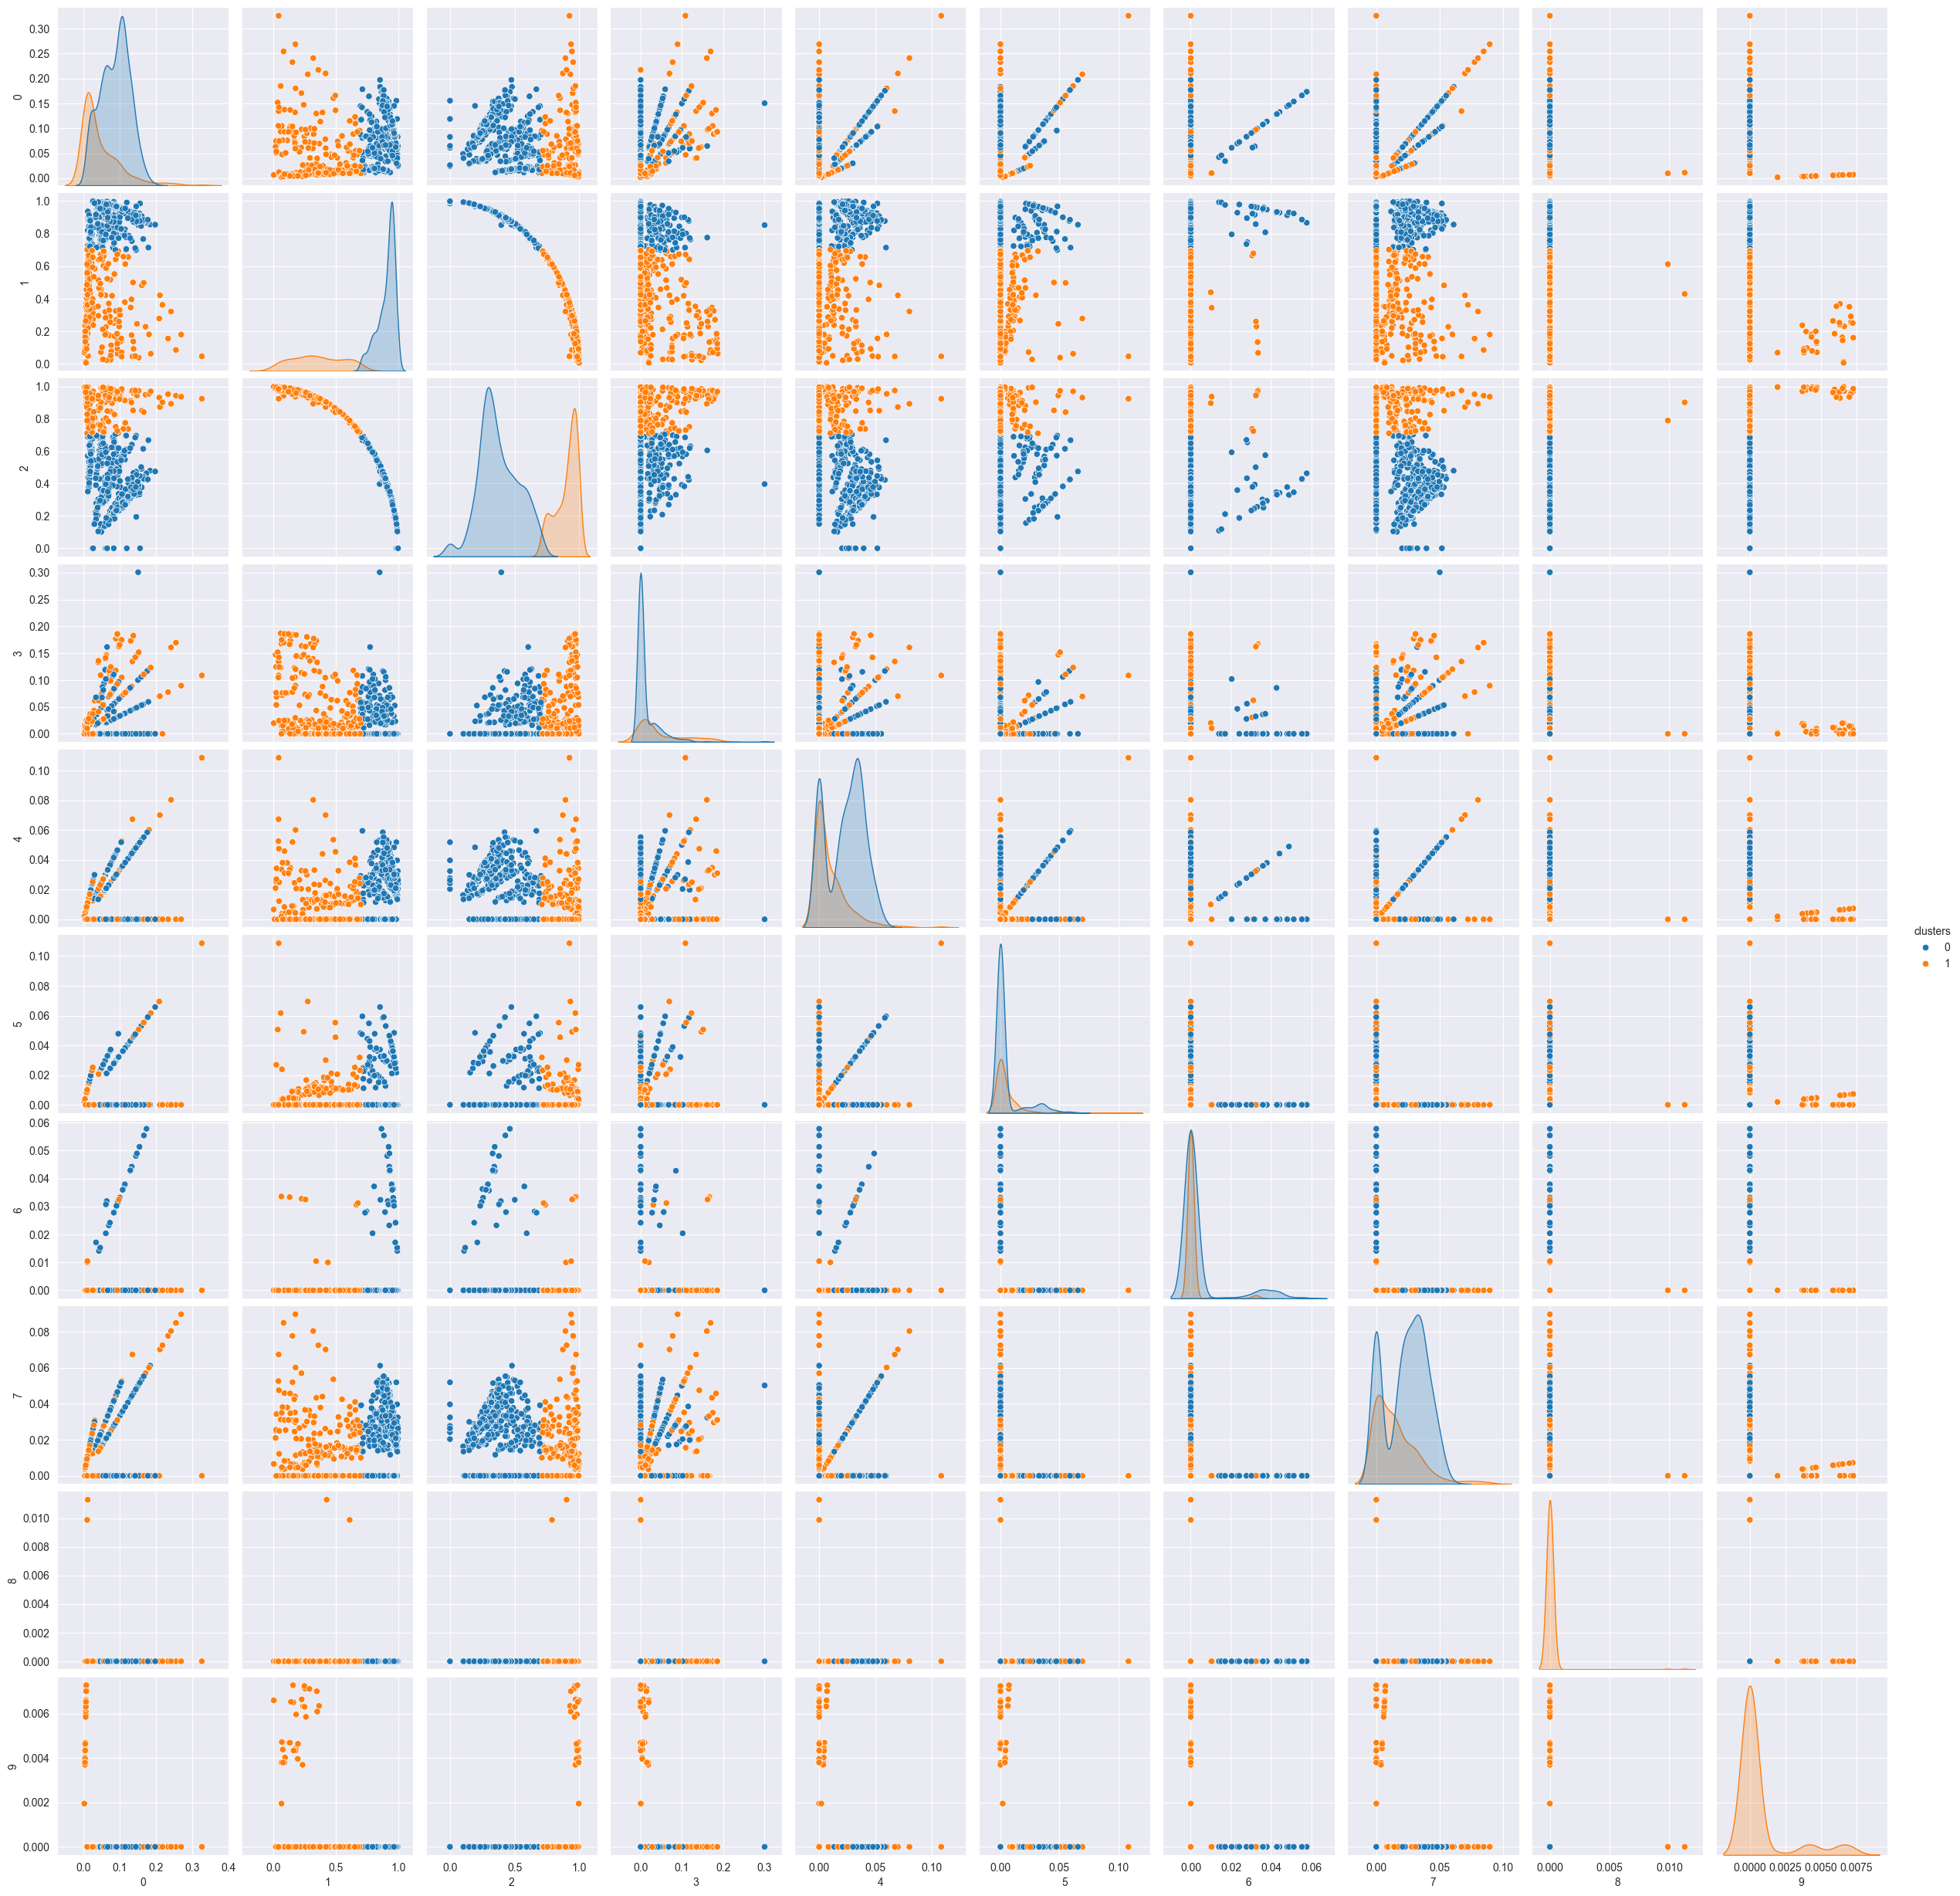

In [12]:
X_normalized_df = pd.DataFrame(X_normalized)
X_normalized_df['clusters'] = clusters_norm
sn.pairplot(X_normalized_df, hue='clusters')

### Question n°3
Étudiez l'impact du paramètre `linkage` sur les résultats de votre clustering hiérarchique.
- Pour rappel, ce paramètre désigne la manière dont est calculée la distance entre deux clusters, pour décider lesquels réunir à une itération donnée.
- Construisez un graphique montrant la valeur du coefficient silhouette en fonction de la méthode utilisée.

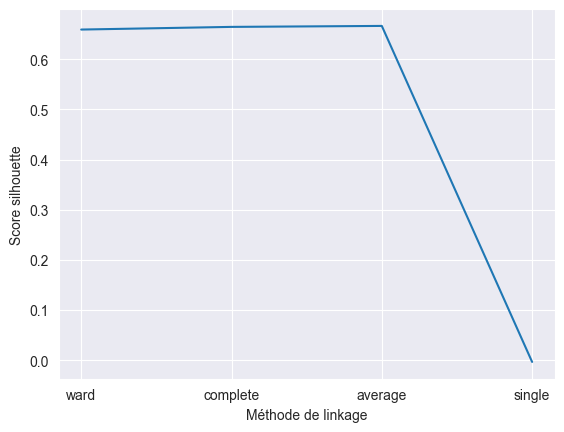

Meileure méthode : average avec un score de 66.63%.


In [13]:
methodes = ['ward', 'complete', 'average', 'single']
silhouette_scores = []

for m in methodes:
    clustering_hierarchie = AgglomerativeClustering(n_clusters=2, linkage=m)
    clusters = clustering_hierarchie.fit_predict(X_normalized)
    silhouette_scores.append(silhouette_score(X_normalized, clusters))
    
plt.plot(methodes, silhouette_scores)
plt.xlabel("Méthode de linkage")
plt.ylabel("Score silhouette")
plt.show()

best_score = np.max(silhouette_scores)
best_method = methodes[np.argmax(silhouette_scores)]
print(F"Meileure méthode : {best_method} avec un score de {100*round(best_score, 4)}%.")

## 3 - Comparaison des différents clustering

Nous allons à présent comparer les résultats obtenus avec les autres algorithmes de clustering proposés par _Scikit-Learn_.
- Testez ces différents algorithmes, et calculez à chaque fois le coefficient de slihouette obtenu.
- Pour les algorithmes qui ne demandent pas de préciser le nombre de clusters à construire :
    - Affichez le nombre de clusters déduit par l'algorithme.

Présentez une synthèse de vos résultats sous forme d'un tableau et d'un graphique.

Liste des algorithmes à prendre en compte : `KMeans`, `DBScan`, `Spectral`, `Affinity_Propagation`, `agglomerativeClustering`, `OPTICS`, `BIRCH`, …

⚠Attention : Pour certains algorithmes, vous devrez jouer avec les paramètres à votre disposition pour parvenir à obtenir au moins deux clusters.

KMeans 0.6696472100159327
DBScan -0.0680674672757958
spectral 0.6708132345704846
affinity_propagation 0.3287212433644313
agglomerativeClustering 0.6590629902788021
OPTICS -0.14031700895888385
BIRCH 0.6426174074629901


C:\Users\Administrateur\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\cluster\_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


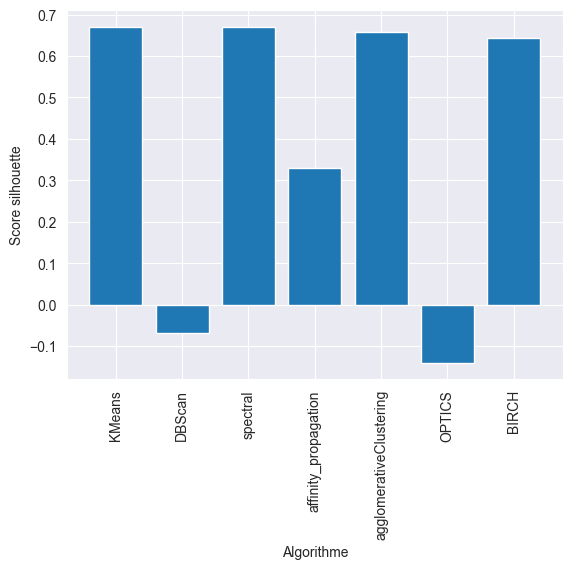

               KMeans    DBScan  spectral  affinity_propagation  \
Score        0.669647 -0.068067  0.670813              0.328721   
Nb Clusters  2.000000  3.000000  2.000000             22.000000   

             agglomerativeClustering     OPTICS     BIRCH  
Score                       0.659063  -0.140317  0.642617  
Nb Clusters                 2.000000  48.000000  2.000000  
⚠Risque de message d'alerte…


In [14]:
algorithmes = [KMeans(n_clusters=2, n_init='auto'), DBSCAN(eps=0.1), SpectralClustering(n_clusters=2) ,AffinityPropagation(), AgglomerativeClustering(), OPTICS(), Birch(n_clusters=2, threshold=0.2)]
algorithmes_names = ['KMeans', 'DBScan', 'spectral', 'affinity_propagation', 'agglomerativeClustering', 'OPTICS', 'BIRCH']
silhouette_scores = []
nb_cluster = []

i =0
for algo in algorithmes:
    clusters = algo.fit_predict(X_normalized)
    silhouette_scores.append(silhouette_score(X_normalized, clusters))
    nb_cluster.append(int(len(np.unique(clusters))))
    print(algorithmes_names[i], silhouette_score(X_normalized, clusters))
    i+=1
    
plt.bar(algorithmes_names, silhouette_scores)
plt.xlabel("Algorithme")
plt.ylabel("Score silhouette")
plt.xticks(rotation=90)
plt.show()


results = pd.DataFrame(data=[silhouette_scores, nb_cluster], index=["Score", 'Nb Clusters'], columns=algorithmes_names)
print(results.head())
print("⚠Risque de message d'alerte…")

# Fin du TP !